In [1]:
from pandas import DataFrame
import pandas as pd

### Extract Train Data

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_train = df_train.dropna() # Clean the NaN data
df_train.head(10)

,CHD_OR_MI,SEX,AGE,HEALTH,PHYSICAL_HEALTH,MENTAL_HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,SKIN_CANCER,...,SMOKE,TABACCO_PRODUCTS,E_CIGARETTES,HEAVY_DRINKERS,HIV,FRUITS,VEGETABLES,FRIED_POTATOES,ETHNICITY,ID
0,1.0,1,34,1.0,1.0,2.0,1.0,1.0,2.0,2.0,...,2.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,1,PID2022_316043
4,1.0,2,21,1.0,1.0,2.0,1.0,1.0,1.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,2.0,1,PID2022_308442
5,1.0,2,44,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,3.0,3.0,1.0,1.0,2.0,2.0,3.0,3,PID2022_114786
6,1.0,2,43,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,3.0,1,PID2022_222132
7,1.0,2,56,1.0,1.0,1.0,1.0,2.0,1.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,1,PID2022_246002
8,1.0,2,72,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,1,PID2022_429870
9,1.0,1,80,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,2.0,3.0,3.0,1.0,2.0,1.0,1.0,2.0,1,PID2022_283303
12,1.0,2,63,1.0,3.0,1.0,1.0,1.0,1.0,2.0,...,2.0,3.0,4.0,1.0,2.0,1.0,2.0,1.0,1,PID2022_415520
13,1.0,2,74,1.0,3.0,3.0,2.0,2.0,2.0,1.0,...,2.0,3.0,3.0,1.0,2.0,2.0,1.0,3.0,1,PID2022_344563
14,1.0,1,70,1.0,1.0,2.0,1.0,1.0,2.0,2.0,...,1.0,3.0,4.0,1.0,2.0,2.0,1.0,3.0,1,PID2022_391089


In [3]:
from imblearn.over_sampling import SMOTE

id_head = "ID"

def standardization(df: DataFrame):
    min_value = df.min()
    max_value = df.max()
    return (df - min_value) / (max_value - min_value)

def extract_x_y(df: DataFrame):
    y_head = "CHD_OR_MI"
    y_data = df[y_head]

    x_data = df.drop(columns=[y_head, id_head])
    x_data = standardization(x_data)
    return x_data, y_data

def apply_smote(x_data, y_data):
    smote = SMOTE(sampling_strategy='minority')
    x_resampled, y_resampled = smote.fit_resample(x_data, y_data)
    return x_resampled, y_resampled

x_train, y_train = extract_x_y(df_train)
x_train, y_train = apply_smote(x_train, y_train)


# print(x_train)
y_train.value_counts() # Desbalanceo

CHD_OR_MI
1.0    193733
0.0    193733
Name: count, dtype: int64

In [4]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=10) 
x_selected = selector.fit_transform(x_train, y_train) 
selected_features = x_train.columns[selector.get_support()] 
print("Selected features:", selected_features)

x_train = x_train[selected_features]

x_train = x_train.sample(n=100000, random_state=42) 
y_train = y_train.loc[x_train.index]

Selected features: Index(['SEX', 'AGE', 'HEALTH', 'PHYSICAL_HEALTH', 'PHYSICAL_ACTIVITIES',
       'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL', 'ARTHRITIS', 'DIFFICULTY_WALKING',
       'SMOKE'],
      dtype='object')


In [5]:
from tensorflow.python.keras.layers import Dense, InputLayer, Dropout
from tensorflow.python.keras import Sequential, optimizers

model = Sequential(
    [
        InputLayer(input_shape=[len(x_train.keys())]),
        Dense(32, activation="relu"),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(10, activation="relu"),
        Dense(1, activation="sigmoid")  # Clasificación Binaria
    ]
)

op = optimizers.adam_v2.Adam(learning_rate=0.001)# 0.00001 
loss_function = "binary_crossentropy"
model.compile(optimizer=op, loss=loss_function, metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 15,253
Trainable params: 15,253
Non-trainable params: 0
____________________________________________________

In [6]:
from tensorflow.python.keras.engine import data_adapter

def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset # Patch Error

# TRAIN DATA
hist = model.fit(x_train, y_train, epochs=100)

Epoch 1/100
3125/3125 [==============================] - 8s 2ms/step - loss: 0.5056 - accuracy: 0.7553
Epoch 2/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.4966 - accuracy: 0.7611
Epoch 3/100
3125/3125 [==============================] - 8s 2ms/step - loss: 0.4938 - accuracy: 0.7626
Epoch 4/100
3125/3125 [==============================] - 8s 2ms/step - loss: 0.4911 - accuracy: 0.7654
Epoch 5/100
3125/3125 [==============================] - 8s 2ms/step - loss: 0.4870 - accuracy: 0.7663
Epoch 6/100
3125/3125 [==============================] - 7s 2ms/step - loss: 0.4810 - accuracy: 0.7698
Epoch 7/100
3125/3125 [==============================] - 8s 3ms/step - loss: 0.4672 - accuracy: 0.7764
Epoch 8/100
3125/3125 [==============================] - 8s 2ms/step - loss: 0.4569 - accuracy: 0.7812
Epoch 9/100
3125/3125 [==============================] - 8s 2ms/step - loss: 0.4516 - accuracy: 0.7827
Epoch 10/100
3125/3125 [==============================] - 7s 2ms/step - l

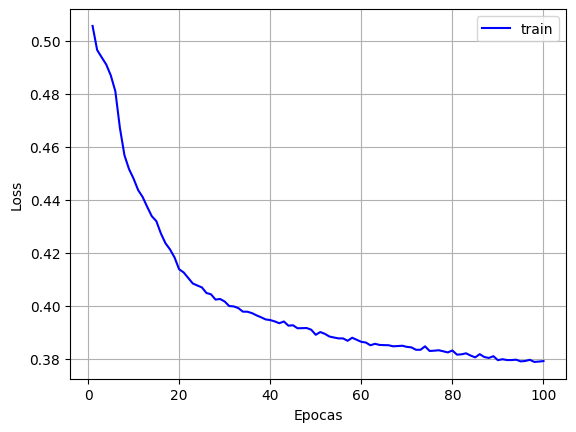

In [7]:
import matplotlib.pyplot as plt


def plot_data(hist):
    loss = hist.history["loss"]
    # loss_mse = hist.history["mse"]
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "b-", label="train")
    plt.xlabel("Epocas")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_data(hist)


In [8]:
df_test_private = pd.read_csv('./data/test_private.csv')
df_test_public = pd.read_csv('./data/test_public.csv')

len_private = df_test_private.shape[0]
len_public = df_test_public.shape[0]

df_test = pd.concat([df_test_private, df_test_public], axis=0) 
df_test.reset_index(drop=True, inplace=True)

x_test_Ids = df_test[id_head]
x_test = df_test.drop(columns=[id_head])
x_test = x_test[selected_features]
x_test = standardization(x_test)

x_test.head(10)


,SEX,AGE,HEALTH,PHYSICAL_HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,ARTHRITIS,DIFFICULTY_WALKING,SMOKE
0,1.0,0.612903,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.661290,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,1.0,0.193548,0.0,0.0,1.0,0.0,NaN,1.0,1.0,1.0
3,1.0,0.177419,1.0,0.5,0.0,0.0,NaN,1.0,1.0,1.0
4,1.0,0.403226,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
5,1.0,0.258065,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,1.0,0.741935,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,0.0,0.758065,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
8,1.0,0.564516,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
9,0.0,0.387097,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0


In [9]:
predictions_proba = model.predict(x_test)
predictions = (predictions_proba > 0.5).astype(int).flatten()

results = pd.DataFrame({
    'ID': x_test_Ids,
    'CHD_OR_MI': predictions
})


results['CHD_OR_MI'].value_counts(normalize=True)

#positive_results = results[results['CHD_OR_MI'] == 1]
#positive_results.head(278)

CHD_OR_MI
1    0.576476
0    0.423524
Name: proportion, dtype: float64

In [10]:
results.to_csv('resultados.csv', index=False)